# One-shot learning with Siamese Networks

This notebook is the forth part of the paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) coded with PyTorch framework. 

This part presents one-shot learning evalution: classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. Method is well described in 4.3 part of the article. Idea is the following:

- Test image $x$ to classify into $C$ classes. 
- Support set: $C$ additional (maybe previously unseen) images of each class: $\{ x_i \}_{i=1}^{C}$
- Query the network to find the best ressembling support set image to the test image:

```
      test image ------[CNN]---- features ----\
                                               \
additional image 1 ---[CNN]---- features ---[is same?] ---- Proba class 1
additional image 2 ---[CNN]---- features ---[is same?] ---- Proba class 2  
    ...                                  
additional image C ---[CNN]---- features ---[is same?] ---- Proba class C
```
- How to choose additional images ?


## 20-way with-in alphabet classification

- An alphabet is taken from the evalution set
- Random 20 characters are sampled from this alphabet ($C=20$)
- Two drawers are selected from the selected for evaluation drawers
    - First drawer -> 20 characters -> 20 test images
    - Second drawer -> 20 characters -> 20 additional images
- 20 one-shot learning trials


References:
- [paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- [omniglot](https://github.com/brendenlake/omniglot)
- [keras-oneshot](https://github.com/sorenbouma/keras-oneshot)

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import cv2

In [3]:
sys.path.append("..")

In [4]:
HAS_GPU = True

Setup trained siamese networks

In [5]:
import torch
from torch.autograd import Variable
from torch.nn.functional import sigmoid

from model import SiameseNetworks
from common_utils.training_utils import load_checkpoint
from glob import glob

In [6]:
logs_path = os.path.join('logs', 'siamese_networks_verification_task_20171126_1154')

In [7]:
siamese_net = SiameseNetworks(input_shape=(105, 105, 1))
if HAS_GPU and torch.cuda.is_available():
    siamese_net = siamese_net.cuda()
    
best_model_filenames = glob(os.path.join(logs_path, "model_val_acc=*"))
assert len(best_model_filenames) == 1
load_checkpoint(best_model_filenames[0], siamese_net)

Load checkpoint: logs/siamese_networks_verification_task_20171126_1154/model_val_acc=0.8557.pth.tar


## 20-way alphabet classification

In [59]:
seed = 12345
np.random.seed(seed)

OMNIGLOT_REPO_PATH='omniglot'

TEST_DATA_PATH = os.path.join(OMNIGLOT_REPO_PATH, 'python', 'images_evaluation')
test_alphabets = !ls {TEST_DATA_PATH}
test_alphabets = list(test_alphabets)

assert len(test_alphabets) > 1, "%s" % test_alphabets[0]        
        
test_alphabet_char_id_drawer_ids = {}
for a in test_alphabets:
    res = !ls "{os.path.join(TEST_DATA_PATH, a)}"
    char_ids = list(res)
    test_alphabet_char_id_drawer_ids[a] = {}
    for char_id in char_ids:
        res = !ls "{os.path.join(TEST_DATA_PATH, a, char_id)}"
        test_alphabet_char_id_drawer_ids[a][char_id] = [_id[:-4] for _id in list(res)]


# Sample 12 drawers out of 20
all_drawers_ids = np.arange(20) 
train_drawers_ids = np.random.choice(all_drawers_ids, size=12, replace=False)
# Sample 4 drawers out of remaining 8
eval_drawers_ids = np.array(list(set(all_drawers_ids) - set(train_drawers_ids)))

def create_str_drawers_ids(drawers_ids):
    return ["_{0:0>2}".format(_id) for _id in drawers_ids]

eval_drawers_ids = create_str_drawers_ids(eval_drawers_ids)

In [60]:
from torchvision.transforms import ToTensor
from common_utils.dataflow import TransformedDataset

In [61]:
from common_utils.dataflow_visu_utils import display_basic_dataset
from dataflow import OmniglotDataset

In [62]:
import matplotlib.pylab as plt
%matplotlib inline

We pick an alphabet (and loop on all test alphabets) and sample randomly 20 characters

In [65]:
len(test_alphabet_char_id_drawer_ids), test_alphabet_char_id_drawer_ids.keys()

(20,
 dict_keys(['Sylheti', 'Avesta', 'Manipuri', 'Old_Church_Slavonic_(Cyrillic)', 'Gurmukhi', 'Malayalam', 'Atlantean', 'Ge_ez', 'Syriac_(Serto)', 'Keble', 'Tibetan', 'Kannada', 'Mongolian', 'Atemayar_Qelisayer', 'Angelic', 'Glagolitic', 'Aurek-Besh', 'ULOG', 'Oriya', 'Tengwar']))

In [63]:
random_alphabet_index = np.random.randint(len(test_alphabet_char_id_drawer_ids))
alphabet = list(test_alphabet_char_id_drawer_ids.keys())[random_alphabet_index]
alphabet

'ULOG'

In [66]:
two_test_drawers_ids = np.random.choice(eval_drawers_ids, size=2, replace=False)

alphabet_char_id_drawers_ids = {}
char_id_drawer_ids = test_alphabet_char_id_drawer_ids[alphabet]    
random_chars = np.random.choice(list(char_id_drawer_ids.keys()), size=20, replace=False).tolist()
alphabet_char_id_drawers_ids[alphabet] = {}
for char_id in char_id_drawer_ids:
    if char_id in random_chars:
        alphabet_char_id_drawers_ids[alphabet][char_id] = char_id_drawer_ids[char_id]
        
test_images_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                          alphabet_char_id_drawers_ids=alphabet_char_id_drawers_ids, 
                          drawers_ids=two_test_drawers_ids[0])

additional_images_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                          alphabet_char_id_drawers_ids=alphabet_char_id_drawers_ids, 
                          drawers_ids=two_test_drawers_ids[1])    

In [67]:
len(test_images_ds), len(additional_images_ds)

(20, 20)

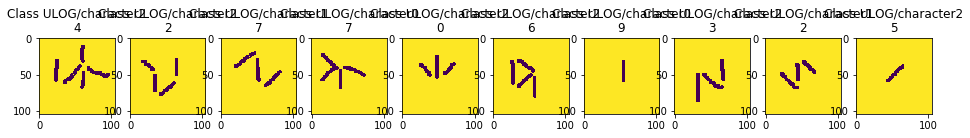

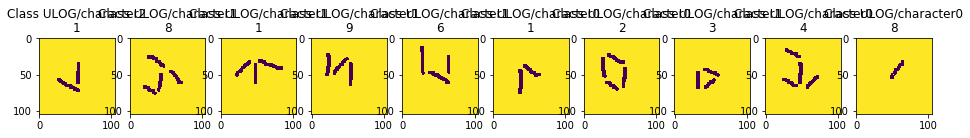

In [68]:
display_basic_dataset(test_images_ds, max_datapoints=len(test_images_ds), n_cols=10, figsize=(16, 4))

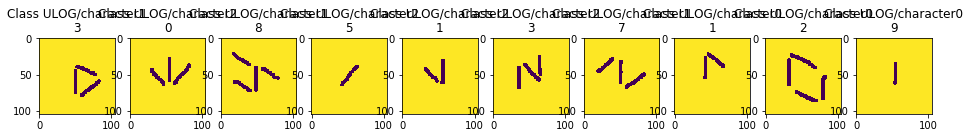

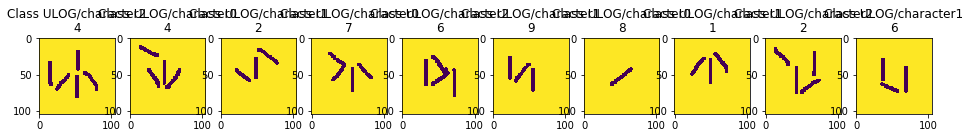

In [69]:
display_basic_dataset(additional_images_ds, max_datapoints=len(additional_images_ds), n_cols=10, figsize=(16, 4))

In [70]:
# Transform string label to class index:
y_transform = lambda y: torch.LongTensor([random_chars.index(os.path.basename(y))])

test_images = TransformedDataset(test_images_ds, x_transforms=ToTensor(), y_transforms=y_transform)
additional_images = TransformedDataset(additional_images_ds, x_transforms=ToTensor(), y_transforms=y_transform)

One-shot learning evaluation

In [77]:
batch_additional_x = []
batch_additional_y = []

for x, y in additional_images:
    batch_additional_x.append(x)
    batch_additional_y.append(y)

batch_additional_x = torch.cat(batch_additional_x).unsqueeze(dim=1)
batch_additional_y = torch.cat(batch_additional_y)

if HAS_GPU and torch.cuda.is_available():
    batch_additional_x = batch_additional_x.cuda()
    
batch_additional_x = Variable(batch_additional_x, volatile=True)

In [75]:
batch_additional_x.size()

torch.Size([20, 1, 105, 105])

In [72]:
from common_utils.dataflow_visu_utils import _to_ndarray, display_batches

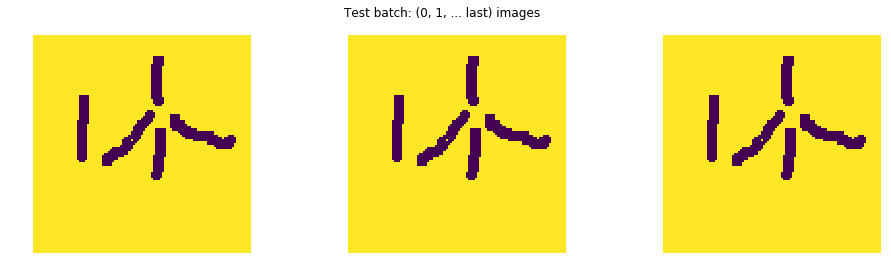

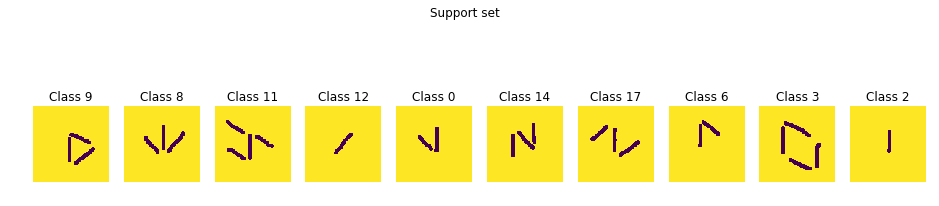

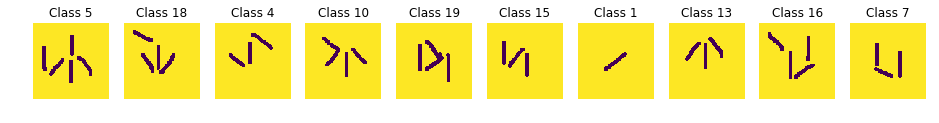

In [73]:
for test_x, test_y in test_images:
    batch_test_x = test_x.expand_as(batch_additional_x)
    plt.figure(figsize=(16, 4))
    plt.suptitle("Test batch: (0, 1, ... last) images")
    plt.subplot(131)
    img = _to_ndarray(batch_test_x[0, :, :, :])    
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(132)
    img = _to_ndarray(batch_test_x[1, :, :, :])    
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(133)
    img = _to_ndarray(batch_test_x[-1, :, :, :])    
    plt.imshow(img)
    plt.axis('off')

    
    n_cols = 10
    plt.figure(figsize=(16, 4))
    plt.suptitle("Support set")
    for j in range(len(batch_additional_y)):
        if j > 0 and j % n_cols == 0:
            plt.figure(figsize=(16, 4))

        x = _to_ndarray(batch_additional_x[j, :, :, :].data)
        y = batch_additional_y[j, ...]

        plt.subplot(1, n_cols, (j % n_cols) + 1)
        plt.imshow(x)
        plt.axis('off')
        plt.title("Class {}".format(y))

        
    break


One-shot learning accuracy:  0.4
One-shot learning accuracy@3:  0.8


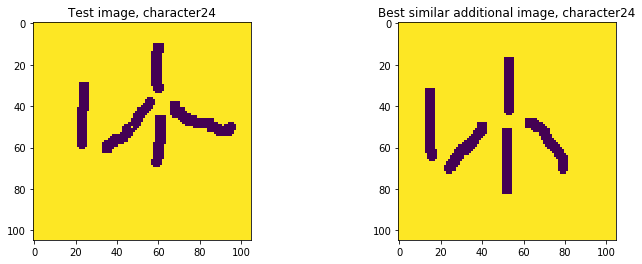

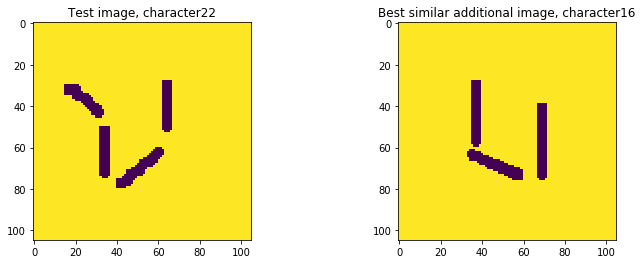

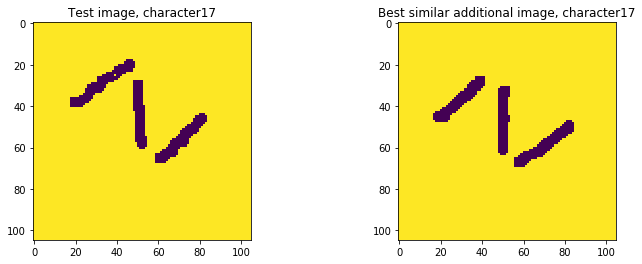

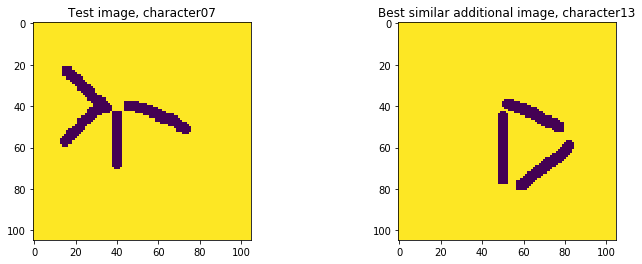

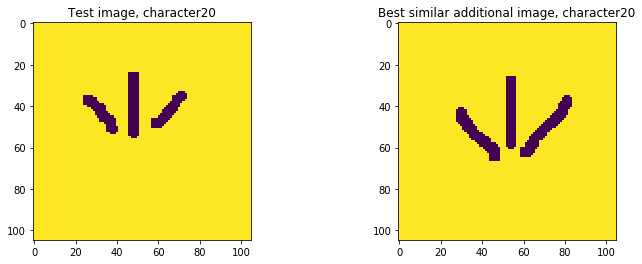

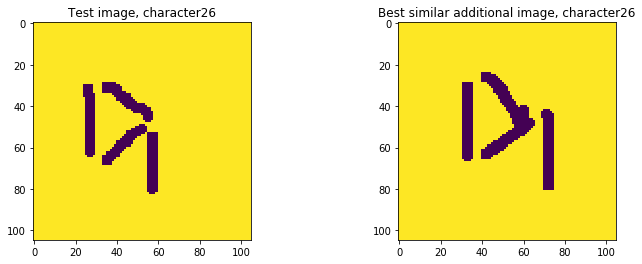

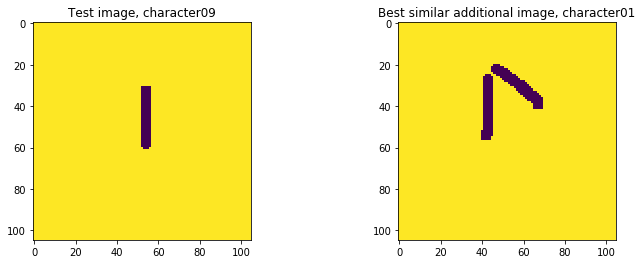

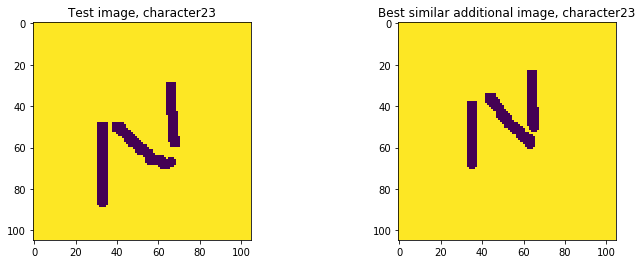

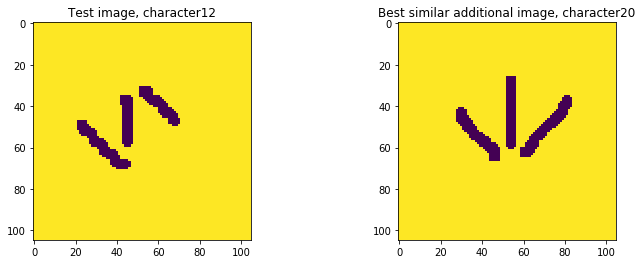

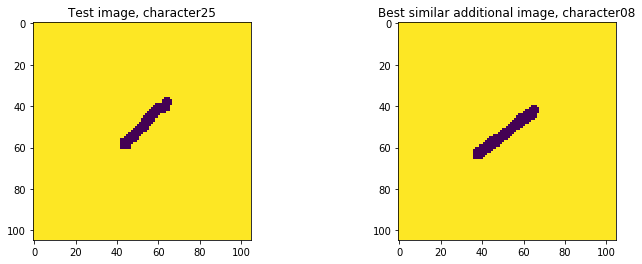

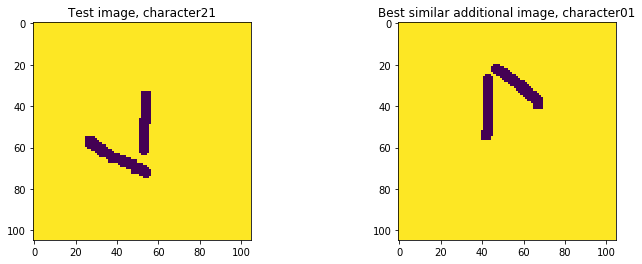

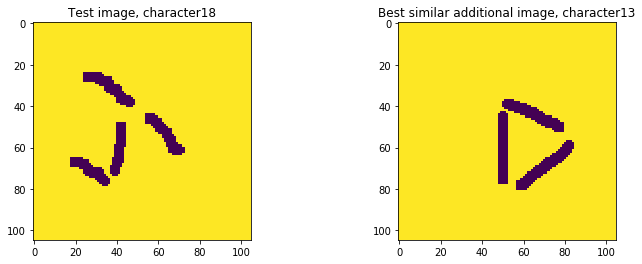

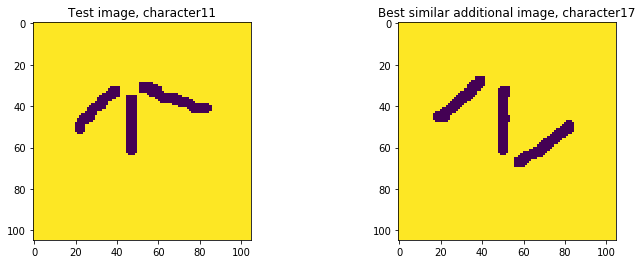

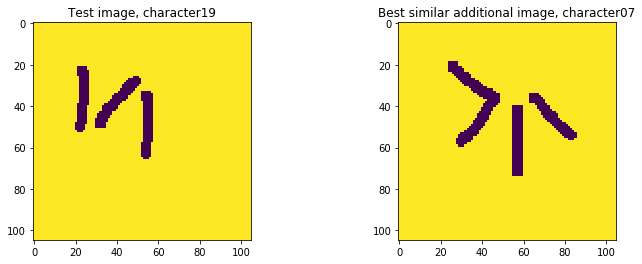

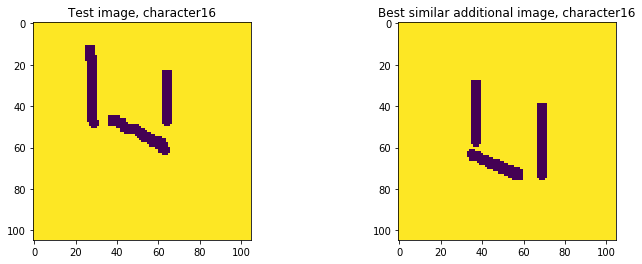

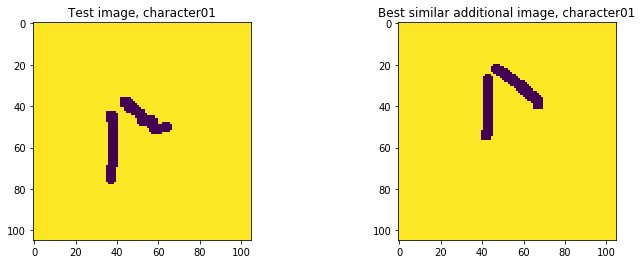

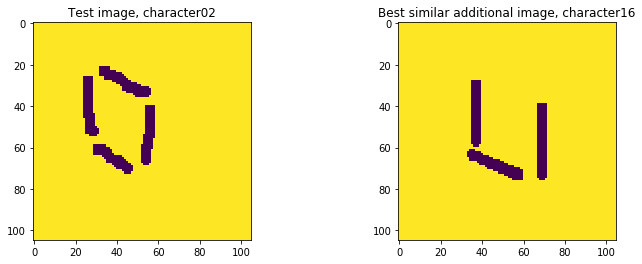

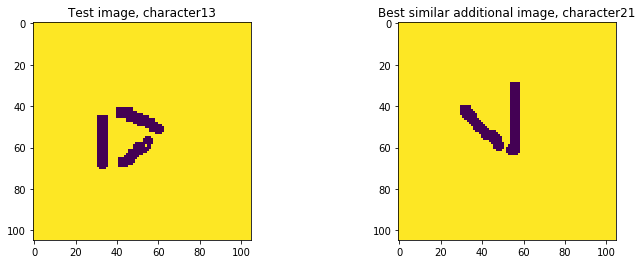

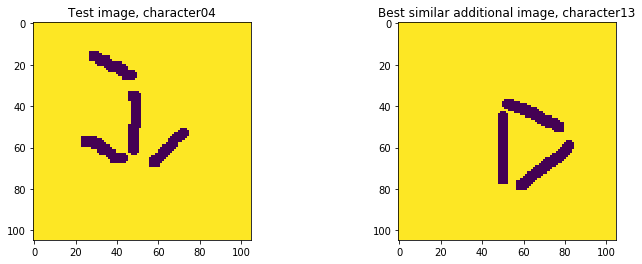

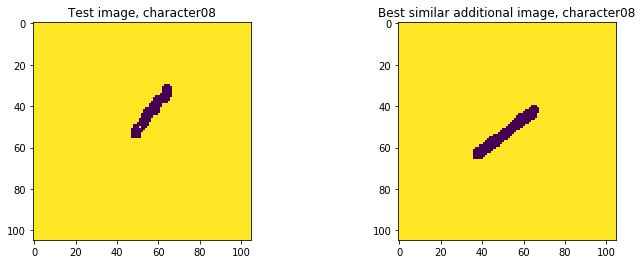

In [74]:
siamese_net.eval()

accuracy = 0.0
accuracy_top3 = 0.0

for test_x, test_y in test_images:
    batch_test_x = test_x.expand_as(batch_additional_x)
    if HAS_GPU and torch.cuda.is_available():
        batch_test_x = batch_test_x.cuda()

    batch_test_x = Variable(batch_test_x, volatile=True)

    y_logits = siamese_net(batch_test_x, batch_additional_x)
    y_probas = sigmoid(y_logits)
        
    y_probas_topk, indices_topk = torch.topk(y_probas.data, k=3, dim=0, largest=True)
    if indices_topk.is_cuda:
        indices_topk = indices_topk.cpu()
    if len(indices_topk.size()) > 1:
        indices_topk = indices_topk.view(-1)        
    classes_topk = batch_additional_y[indices_topk]
        
    accuracy += (test_y == classes_topk[0]).sum()
    accuracy_top3 += (test_y == classes_topk[:3]).sum()

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    index = int(test_y[0])
    plt.title("Test image, %s" % random_chars[index])
    plt.imshow(_to_ndarray(test_x))
    plt.subplot(122)
    index = int(classes_topk[0])
    plt.title("Best similar additional image, %s" % random_chars[index])
    index = int(indices_topk[0])
    plt.imshow(_to_ndarray(batch_additional_x.data[index, :, :, :]))
        
accuracy /= len(test_images)
accuracy_top3 /= len(test_images)

print("One-shot learning accuracy: ", accuracy)
print("One-shot learning accuracy@3: ", accuracy_top3)

Let's perform 400 trials : (2 x 20-way trial on one alphabet) x (10 alphabets)

In [58]:
siamese_net.eval()
two_test_drawers_ids = np.random.choice(test_drawers_ids, size=2, replace=False)

mean_accuracy = []
mean_accuracy_top3 = []

for alphabet in test_alphabet_char_id_drawer_ids:
    
    print("Alphabet: ", alphabet)
    
    for _ in range(2):
    
        alphabet_char_id_drawers_ids = {}
        char_id_drawer_ids = test_alphabet_char_id_drawer_ids[alphabet]    
        random_chars = np.random.choice(list(char_id_drawer_ids.keys()), size=20, replace=False).tolist()
        alphabet_char_id_drawers_ids[alphabet] = {}
        for char_id in char_id_drawer_ids:
            if char_id in random_chars:
                alphabet_char_id_drawers_ids[alphabet][char_id] = char_id_drawer_ids[char_id]

        test_images_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                                  alphabet_char_id_drawers_ids=alphabet_char_id_drawers_ids, 
                                  drawers_ids=two_test_drawers_ids[0])

        additional_images_ds = OmniglotDataset("Test", data_path=TEST_DATA_PATH, 
                                  alphabet_char_id_drawers_ids=alphabet_char_id_drawers_ids, 
                                  drawers_ids=two_test_drawers_ids[1])

        # Transform string label to class index:
        y_transform = lambda y: torch.FloatTensor([random_chars.index(os.path.basename(y))])

        test_images = TransformedDataset(test_images_ds, x_transforms=ToTensor(), y_transforms=y_transform)
        additional_images = TransformedDataset(additional_images_ds, x_transforms=ToTensor(), y_transforms=y_transform)

        batch_additional_x = []
        batch_additional_y = []

        for x, y in additional_images:
            batch_additional_x.append(x)
            batch_additional_y.append(y)

        batch_additional_x = torch.cat(batch_additional_x).unsqueeze(dim=1)
        batch_additional_y = torch.cat(batch_additional_y)

        if HAS_GPU and torch.cuda.is_available():
            batch_additional_x = batch_additional_x.cuda()

        batch_additional_x = Variable(batch_additional_x, volatile=True)

        accuracy = 0.0
        accuracy_top3 = 0.0

        for test_x, test_y in test_images:
            batch_test_x = test_x.expand_as(batch_additional_x)
            if HAS_GPU and torch.cuda.is_available():
                batch_test_x = batch_test_x.cuda()

            batch_test_x = Variable(batch_test_x, volatile=True)

            y_logits = siamese_net(batch_test_x, batch_additional_x)
            y_probas = sigmoid(y_logits)
            y_probas_topk, indices_topk = torch.topk(y_probas.data, k=3, dim=0, largest=True)
            if indices_topk.is_cuda:
                indices_topk = indices_topk.cpu()
            if len(indices_topk.size()) > 1:
                indices_topk = indices_topk.view(-1)        
            classes_topk = batch_additional_y[indices_topk]

            accuracy += (test_y == classes_topk[0]).sum()
            accuracy_top3 += (test_y == classes_topk[:3]).sum()

        accuracy /= len(test_images)
        accuracy_top3 /= len(test_images)

        print("One-shot learning accuracy: ", accuracy)
        print("One-shot learning accuracy@3: ", accuracy_top3)
        mean_accuracy.append(accuracy)
        mean_accuracy_top3.append(accuracy_top3)        
    
mean_accuracy = np.mean(mean_accuracy)
mean_accuracy_top3 = np.mean(mean_accuracy_top3)
print("\nOne-shot learning mean accuracy: ", mean_accuracy)
print("One-shot learning mean accuracy@3: ", mean_accuracy_top3)


Alphabet:  Sylheti
One-shot learning accuracy:  0.25
One-shot learning accuracy@3:  0.45
One-shot learning accuracy:  0.15
One-shot learning accuracy@3:  0.4
Alphabet:  Avesta
One-shot learning accuracy:  0.45
One-shot learning accuracy@3:  0.65
One-shot learning accuracy:  0.35
One-shot learning accuracy@3:  0.75
Alphabet:  Manipuri
One-shot learning accuracy:  0.35
One-shot learning accuracy@3:  0.9
One-shot learning accuracy:  0.25
One-shot learning accuracy@3:  0.8
Alphabet:  Old_Church_Slavonic_(Cyrillic)
One-shot learning accuracy:  0.65
One-shot learning accuracy@3:  0.95
One-shot learning accuracy:  0.8
One-shot learning accuracy@3:  0.95
Alphabet:  Gurmukhi
One-shot learning accuracy:  0.3
One-shot learning accuracy@3:  0.6
One-shot learning accuracy:  0.3
One-shot learning accuracy@3:  0.65
Alphabet:  Malayalam
One-shot learning accuracy:  0.35
One-shot learning accuracy@3:  0.55
One-shot learning accuracy:  0.35
One-shot learning accuracy@3:  0.65
Alphabet:  Atlantean
One-sh

Another way to evaluate one-shot learning on K random tests. Same as in [keras-oneshot](https://github.com/sorenbouma/keras-oneshot/blob/master/SiameseNet.ipynb), method `make_oneshot_task`.

Idea is 
- again to pick a random alphabet from validation dataset
- select two drawers
- run K trials on random test characters.

In [ ]:
def make_oneshot_task(N):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    X=self.data[s]
    n_classes, n_examples = X.shape[0],X.shape[1]
    if language is not None:
        low, high = self.categories[s][language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)
        indices = rng.randint(0,self.n_examples,size=(N,))

    else:#if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        indices = rng.randint(0,self.n_examples,size=(N,))
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N,self.w,self.h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]